# Basic Text Classification with TensorFlow

In this set of notes, we'll begin to discuss the problem of *text classification*. Text classification is a common problem in which we aim to classify pieces of text into different categories. These categories might be about:

- **Subject matter**: is this news article about news, fashion, finance?
- **Emotional valence**: is this tweet happy or sad? Excited or calm? This particular class of questions is so important that it has its own name: *sentiment analysis.* 
- **Automated content moderation**: is this Facebook comment a possible instance of abuse or harassment? Is this Reddit thread promoting violence? Is this email spam? 

These are all very different kinds of questions, but many of the same techniques can be used. In these notes, we'll do a simple example of subject matter classification. In future notes, we'll also do some sentiment analysis. 

### Optional Review

- [Term-document matrices](https://nbviewer.jupyter.org/github/PhilChodrow/PIC16A/blob/master/content/NLP/NLP_1.ipynb). 
- [Sentiment analysis](https://nbviewer.jupyter.org/github/PhilChodrow/PIC16A/blob/master/content/NLP/NLP_3.ipynb). 

### Heads Up

To run the code in this notebook, you will actually need to **update TensorFlow**. To do this, open up a terminal and type the following two lines: 

```bash
conda activate PIC16B
pip install tensorflow==2.4
```

In [150]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

# requires update to tensorflow 2.4
# >>> conda activate PIC16B
# >>> pip install tensorflow==2.4
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for embedding viz
import plotly.express as px 
import plotly.io as pio
pio.templates.default = "plotly_white"

For this example, we are going to use a data set containing headlines from a large number of different news articles on the website [HuffPost](https://www.huffpost.com/). I retrieved this data [from Kaggle](https://www.kaggle.com/rmisra/news-category-dataset). 

In [90]:
url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/news/News_Category_Dataset_v2.json"
df  = pd.read_json(url, lines=True)
df  = df[["category", "headline"]]

There are over 200,000 headlines listed here, along with the category in which they appeared on the website. 

In [91]:
df.head()

,category,headline
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


Our task will be to teach an algorithm to classify headlines by predicting the category based on the text of the headline. 

Training a model on this much text data can require a lot of time, so we are going to simplify the problem a little bit, by reducing the number of categories. Let's take a look at which categories we have: 

In [92]:
df.groupby("category").size()

category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          2579
dtype: 

Some of these categories are a little odd:

- "Women"? 
- "Weird News"? 
- What's the difference between "Style," "Style & Beauty," and "Taste"? ). 
- "Parenting" vs. "Parents"? 

Well, there are definitely some questions here! Let's just choose a few categories, and discard the rest: 

In [93]:
categories = ["WEIRD NEWS", "FOOD & DRINK", "SCIENCE"]

df = df[df["category"].apply(lambda x: x in categories)]
df.head()

,category,headline
20,WEIRD NEWS,Weird Father's Day Gifts Your Dad Doesn't Know...
22,WEIRD NEWS,Mystery 'Wolf-Like' Animal Reportedly Shot In ...
61,WEIRD NEWS,A Bag Of Wet Socks Is Apparently Living In The...
72,WEIRD NEWS,Fish Market Buys Freedom For Fred The 70-Pound...
139,WEIRD NEWS,Amazon Admits Alexa Device Eavesdropped On Por...


Next, we'll use a `LabelEncoder` to transform the `category` column into integers. 

**Note**: I couldn't find a way that I was satisfied with to do this in TensorFlow, but if you know a smooth way, let me know! 

In [94]:
le = LabelEncoder()
df["category"] = le.fit_transform(df["category"])
df.head()

,category,headline
20,2,Weird Father's Day Gifts Your Dad Doesn't Know...
22,2,Mystery 'Wolf-Like' Animal Reportedly Shot In ...
61,2,A Bag Of Wet Socks Is Apparently Living In The...
72,2,Fish Market Buys Freedom For Fred The 70-Pound...
139,2,Amazon Admits Alexa Device Eavesdropped On Por...


Later, we'll be able to remember which integers correspond to which classes using the `classes_` attribute of the encoder. 

In [95]:
le.classes_

array(['FOOD & DRINK', 'SCIENCE', 'WEIRD NEWS'], dtype=object)

We're left with a much smaller number of rows, which will be much easier to work with. 

## TensorFlow Datasets

Next, we are going create a TensorFlow data set from our data frame. While we often talk colloquially about data sets, TensorFlow has a special `Dataset` class with a number of convenient capabilities. Use of `Dataset`s is generally optional, but can make it significantly easier to stay organized when writing data pipelines. The `Dataset` class also includes functionality for a wide-variety of data input scenarios, including situations in which the data should be read in chunks-at-a-time from disk. 

The `Dataset` class is useful for all kinds of problems, not just text classification problems. Learn more about it [here](https://www.tensorflow.org/guide/data).

We'll make a dataset with the predictor data (the headline) and target data (the category) separated out. 

In [96]:
data = tf.data.Dataset.from_tensor_slices((df["headline"], df["category"]))

In [97]:
for headline, category in data.take(5):
    print(headline, category)

tf.Tensor(b"Weird Father's Day Gifts Your Dad Doesn't Know He Wants (But He Does)", shape=(), dtype=string) tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(b"Mystery 'Wolf-Like' Animal Reportedly Shot In Montana, Baffles Wildlife Officials", shape=(), dtype=string) tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(b'A Bag Of Wet Socks Is Apparently Living In The White House Press Briefing Room', shape=(), dtype=string) tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(b'Fish Market Buys Freedom For Fred The 70-Pound Octopus', shape=(), dtype=string) tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(b'Amazon Admits Alexa Device Eavesdropped On Portland Family', shape=(), dtype=string) tf.Tensor(2, shape=(), dtype=int64)


Now we'll perform a train-test split. We'll also take out a small validation set. 

In [98]:
data = data.shuffle(buffer_size = len(data))

In [99]:
train_size = int(0.7*len(data))
val_size   = int(0.1*len(data))

train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size)

In [100]:
len(train), len(val), len(test)

(7751, 1107, 2216)

## Standardization and Vectorization

*Standardization* refers to the act of taking a some text that's "messy" in some way and making it less messy. Common standardizations include: 

- Removing capitals. 
- Removing punctuation. 
- Removing HTML elements or other non-semantic content. 

In [101]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation 

*Vectorization* refers to the process of representing text as a vector (array, tensor). For technical details on how TensorFlow carries out the vectorization, check [the docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization). Note that we pass the standardization from above as an argument to the vectorization layer.  

In [102]:
# only the top distinct words will be tracked
max_tokens = 5000

# each headline will be a vector of length 25
sequence_length = 25

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=sequence_length)

We need to *adapt* the vectorization layer to the headlines. In the adaptation process, the vectorization layer learns what words are common in the headlines. 

In [103]:
headlines = train.map(lambda x, y: x)
vectorize_layer.adapt(headlines)

Now we're ready to vectorize each of the data sets. To do so, we define a helper function that operates on our Datasets. Note that our Dataset consists of a bunch of tuples of the form (headline, category) for each data observation. Our helper function therefore accepts and returns two variables. 

**Note**: because we adapted the vectorization layer to the training data, not the validation or testing data, we aren't "cheating" by propagating information from the validation or testing data prior to the training step. 

In [104]:
def vectorize_headline(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), [label]

train = train.map(vectorize_headline)
val   = val.map(vectorize_headline)
test  = test.map(vectorize_headline)

In [105]:
list(train.take(5))

[(<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
  array([[  1, 818, 621,  24,   1,  13, 581,  10,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>),
 (<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
  array([[   1, 3011,  236,    1,  135,  857,   62,    1,   24,    1,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>),
 (<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
  array([[  17,  140,  588,   42, 1450,   16, 1356,    7,  172,    9,  464,
             1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>),
 (<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
  array([[1892,  986,   11,   28,   26,  821,   43,  138,   43,   16, 1579,
             0,    0,    0,    0, 

## Modeling

Phew, that was a lot of data preparation! That's kind of how it is in the world of machine learning: so much of the effort goes into ensuring that your data is correctly formatted and represented. 

Let's now construct a simple model out of some layers. This model is going to have a few new components. 

The most interesting of these, which we are going to come back to, is the `Embedding` layer. 



In [106]:
model = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 3, name="embedding"),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(len(categories))]
)

In [107]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', 
              metrics=['accuracy'])

In [124]:
history = model.fit(train, epochs = 5, validation_data = val)

Epoch 1/5
7751/7751 [==============================] - 15s 2ms/step - loss: 0.2976 - accuracy: 0.8867 - val_loss: 0.2122 - val_accuracy: 0.9332
Epoch 2/5
7751/7751 [==============================] - 14s 2ms/step - loss: 0.2895 - accuracy: 0.8863 - val_loss: 0.1939 - val_accuracy: 0.9404
Epoch 3/5
7751/7751 [==============================] - 15s 2ms/step - loss: 0.2776 - accuracy: 0.8970 - val_loss: 0.1893 - val_accuracy: 0.9440
Epoch 4/5
7751/7751 [==============================] - 14s 2ms/step - loss: 0.2799 - accuracy: 0.8909 - val_loss: 0.1733 - val_accuracy: 0.9431
Epoch 5/5
7751/7751 [==============================] - 15s 2ms/step - loss: 0.2687 - accuracy: 0.8941 - val_loss: 0.1734 - val_accuracy: 0.9359


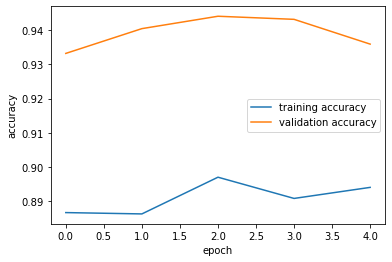

In [125]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training accuracy")
plt.plot(history.history["val_accuracy"], label = "validation accuracy")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

At this point, it would be appropriate to be somewhat disturbed -- can it really be correct that the validation accuracy is *higher* than the training accuracy? That doesn't seem right, does it? The reason this occurs is due to those `Dropout` layers in the model. What these layers do is disable ("drop out") a fixed percentage of the units in each layer, *but only during training.* This turns out to be a good way to reduce the risk of overfitting. Because the units are used during validation and testing, but not during training, it can happen that indeed the validation and testing scores can be higher. 

# Predictions on Unseen Data

In [126]:
model.evaluate(test)

2216/2216 [==============================] - 3s 1ms/step - loss: 0.1774 - accuracy: 0.9449: 0s - loss:


[0.1774236261844635, 0.9449458718299866]

In [127]:
preds = model.predict(test)
preds = np.argmax(preds, axis = 1)

In [128]:
# predictions for the first five entries in the test set
[le.classes_[preds[i]] for i in range(len(preds))][0:5]

['FOOD & DRINK', 'FOOD & DRINK', 'FOOD & DRINK', 'WEIRD NEWS', 'FOOD & DRINK']

# Embeddings

In [129]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [130]:
weights

array([[-0.02156679,  0.01423458, -0.04534481],
       [ 0.11818149, -0.03200598,  0.0841314 ],
       [-0.3924212 ,  0.06091379, -0.34949204],
       ...,
       [ 0.00564263, -0.33875695,  0.07023559],
       [ 0.5385007 , -0.12670958,  0.34135506],
       [ 0.2123102 , -0.2940706 ,  0.04107295]], dtype=float32)

In [131]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
weights = pca.fit_transform(weights)

In [132]:
embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1],
    'x2'   : weights[:,2]
})

In [139]:
embedding_df

,word,x0,x1,x2
0,,-0.058861,-0.119287,-0.216109
1,[UNK],-0.197927,0.007136,-0.160411
2,the,0.321380,-0.404491,-0.295537
3,to,-0.329335,-0.228542,-0.227201
4,a,-0.056358,-0.025196,-0.264756
...,...,...,...,...
4995,cubes,0.818483,-0.034890,-0.065343
4996,crystals,-0.464945,-0.483067,0.100269
4997,crustacean,0.024893,0.137305,0.040491
4998,crushes,-0.547791,0.363577,-0.111961


In [147]:
to_plot = embedding_df.sample(frac = 1)

In [151]:
import plotly.express as px 
fig = px.scatter(to_plot, 
           x = "x0", 
           y = "x1", 
           size = np.ones(len(to_plot)), 
           size_max = 3,hover_name = "word")

fig.show()

You can hover over dots in the image above to see where different words fall in the embedding. Often, it's possible to see that certain "directions" correspond to different categories. 

It's also possible to construct 3d plots of the components, although in this case it's best to use a much smaller set of words. 

In [159]:
to_plot = embedding_df.sample(frac = 0.4)

In [160]:
fig = px.scatter_3d(to_plot, 
           x = "x0", 
           y = "x1", 
           z = "x2",
           size = np.ones(len(to_plot)),
           hover_name = "word",
           size_max = 10)

fig.show()

Since we embedded our words in 3 dimensions, we are able to visualize all the embedding dimensions fairly easily. In modern models, words are embedded in much higher-dimensional spaces. For example, the [Embedding Projector demo](http://projector.tensorflow.org/) supplied by TensorFlow uses a default dimension of 200. 

### Lots of Approaches for Embeddings

An important aspect of text embedding is that it usually appears in neural nets as one of the relatively early layers in the model. This means that there's no one right way to train an embedding. If you have a text model that has some kind of measurable performance (i.e. loss function), you can just slap an embedding layer in at the base of the model and inspect it later to see what it learns! 